In [1]:
import pandas as pd
import numpy as np

In [2]:
def build_arrays(df, time_window=5, stride=3, input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return'] , target_col='5TD_return'):
    """
    A function to transform dataframe into input and output arrays.

    Takes:
    df - input dataframe
    time_window (default=5) - time series length
    stride (default=3) - a step for moving window across dataframe rows
    input_cols (default = 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']) - all input features, that should be included in the input array
    target_col (default = '5TD_return') - target variable, first (newest) value for each input array


    Return tuple (input_array, target_array).

    input_array dim: (number_of_samples x time_window x features_number)
    target_array dim: number_of_samples
    """

    input_array = []
    target_array = []
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)
    for row in range(0, len(df), stride):
        df_slice = df_sorted.iloc[row: row + time_window]
        if df_slice.shape[0]==time_window:
            input_array.append(np.array(df_slice[input_cols].values))
            target_array.append(df_slice[target_col].iloc[0])
    return np.array(input_array), np.array(target_array)

In [3]:
test = pd.read_csv('../raw_data/processed/AAPL.csv')
test.keys()

Index(['ticker', 'date', 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '5TD_return', '10TD_return', '20TD_return'],
      dtype='object')

In [4]:
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '5TD_return', '10TD_return', '20TD_return']
#INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal']

ticker_train_x, ticker_train_y = build_arrays(test,input_cols=INPUT_COLS, target_col='20TD_return', time_window=6, stride=5)

## Redo Function

In [5]:
test = test.rename(columns={'5TD_return':'1D_past_return', '10TD_return': '5D_past_return', '20TD_return':'10D_past_return'})

In [76]:
import random

def build_randomised_arrays(df, time_window=5, stride=3, check_outliers=False, outlier_threshold=1, input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return'], target_col=['1D_past_return', '5D_past_return', '10D_past_return'], 
        outlier_validation={'ATR': [-100, 100], 'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}):
    """
    A function to transform dataframe into input and output arrays.

    Takes:
    df - input dataframe
    time_window (default=5) - time series length
    stride (default=3) - controls the number of windows taken (i.e. max_num_windows = len(df)/strides)
    check_outliers (default=False) - controls whether it checks each window for outliers or not
    input_cols (default = 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']) - all input features, that should 
       be included in the input array target_col (default = '5TD_return') - target variable, first (newest) value for each input array
    target_col - all columns that should be included in target_col
        (default: target_col=['1D_past_return', '5D_past_return', '10D_past_return'])
    outlier_validation - a dict that sets the outlier checks to be completed. Enter data in the format:
        outlier_validation={'column_name': [lower_threshold, upper_threshold]} 
        Example: {'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}

    Return tuple (input_array, target_array).

    input_array dim: (number_of_samples x time_window x features_number)
    target_array dim: (number_of_samples x time_window x returns_numbder)
    """

    input_array = []
    target_array = []
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)    
    max_num_windows = len(df)/stride
    random_index = []
    for i in range(int(max_num_windows)):
        r=random.randint(time_window, len(df)- time_window)
        if r not in random_index: random_index.append(r)
    outlier_count = 0
    for window_start in random_index:
        outlier = False
        df_slice = df_sorted.iloc[window_start: window_start + time_window]
        if check_outliers == True:
            for k, v in outlier_validation.items(): 
                if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
        if df_slice.shape[0]==time_window and outlier==False:
            if outlier_count/max_num_windows >= outlier_threshold:
                return np.array([]), np.array([])
            input_array.append(np.array(df_slice[input_cols].values))
            target_array.append(np.array(df_slice[target_col].values))
        else: outlier_count+=1
    print('random_index', random_index)
    print('outlier_count', outlier_count)
    print('max_num_windows', max_num_windows)
    print('random_index', len(random_index))
    print('input_array', len(input_array))
    print('outlier %', outlier_count/max_num_windows)    
    return np.array(input_array), np.array(target_array)

In [77]:
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
outlier_validation={'1D_past_return': [-0.2, 0.2]}

ticker_train_x, ticker_train_y = build_randomised_arrays(test, stride=50, input_cols=INPUT_COLS, outlier_threshold=1, outlier_validation=outlier_validation, check_outliers=True, target_col=['1D_past_return', '5D_past_return', '10D_past_return'], time_window=30)

random_index [2343, 8698, 2368, 992, 6907, 4767, 2525, 7559, 1816, 6595, 7848, 2303, 3490, 7051, 655, 6412, 1476, 3207, 7524, 2655, 4895, 2582, 5346, 6547, 1698, 621, 6478, 3016, 1467, 2384, 3825, 7906, 5557, 8281, 6838, 7924, 7542, 135, 8577, 7853, 8557, 7614, 1246, 3704, 5020, 5107, 8236, 2315, 1363, 3983, 7665, 4831, 5096, 2016, 7414, 751, 2731, 8210, 993, 1093, 4212, 6780, 4777, 3098, 2090, 5845, 3046, 7345, 6707, 1145, 6515, 5415, 4661, 5095, 4208, 575, 4326, 8265, 6151, 7295, 2636, 2693, 6319, 8786, 2377, 514, 5721, 1107, 4771, 4435, 145, 8295, 6321, 6399, 7663, 3251, 2321, 4262, 6635, 565, 5403, 5132, 8404, 1799, 7772, 7870, 4504, 6291, 2471, 5636, 6027, 7708, 228, 541, 37, 7308, 2413, 2733, 4309, 8780, 8066, 2325, 9048, 8161, 9002, 4441, 8952, 5162, 1479, 8908, 2808, 2252, 1820, 8692, 3357, 836, 4191, 4631, 2330, 3336, 5908, 4643, 4892, 2400, 7441, 5782, 1868, 4500, 2783, 1542, 1227, 5637, 8919, 6749, 8051, 1287, 3649, 4949, 3017, 5793, 2870, 2147, 1879, 7669, 5276, 3864, 7953,

In [75]:
len(test)

9115

In [78]:
ticker_train_x.shape

(169, 30, 15)

In [79]:
test.head(20)

,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,1D_past_return,5D_past_return,10D_past_return
0,AAPL,1984-10-24,57.978007,76.690103,69.424914,-5.139242e+09,387549732,0.003297,19.036526,35.250645,23.135370,-0.000432,0.001254,-0.001687,-0.052010,-0.018263,-0.119206
1,AAPL,1984-10-25,49.247645,56.625203,68.325221,-5.322591e+09,204200382,0.003326,18.051296,32.458308,29.224107,-0.000390,0.001037,-0.001427,-0.009378,-0.022156,-0.060181
2,AAPL,1984-10-26,44.483899,43.374797,58.896701,-5.425815e+09,71070262,0.003286,17.088681,30.521333,33.447714,-0.000548,0.000704,-0.001251,0.009726,-0.055397,-0.026218
3,AAPL,1984-10-29,45.183124,44.997296,48.332432,-5.484525e+09,129780480,0.003117,16.194824,29.881216,32.746222,-0.000641,0.000488,-0.001129,0.000000,-0.025925,-0.003162
4,AAPL,1984-10-30,48.093222,51.703624,46.691906,-5.570994e+09,216248865,0.003048,15.133939,31.950924,31.104445,-0.000608,0.000417,-0.001025,0.048060,-0.060959,0.035265
5,AAPL,1984-10-31,46.756653,48.350460,48.350460,-5.640818e+09,146424986,0.002939,14.131492,30.768700,31.452939,-0.000625,0.000320,-0.000945,0.035598,-0.045126,0.022406
6,AAPL,1984-11-01,48.303866,32.603774,44.219286,-5.695347e+09,200954576,0.002839,13.200648,29.589628,30.247646,-0.000581,0.000291,-0.000872,-0.012899,-0.051285,-0.012899
7,AAPL,1984-11-02,46.838087,27.924528,36.292921,-5.701430e+09,168860009,0.002745,12.710252,28.416912,32.260911,-0.000590,0.000226,-0.000816,-0.064496,-0.064496,-0.019370
8,AAPL,1984-11-05,45.355892,5.658627,22.062310,-5.823577e+09,46713678,0.002746,11.848365,29.571347,29.954593,-0.000640,0.000141,-0.000781,-0.025925,-0.113605,0.006534
9,AAPL,1984-11-06,58.668841,60.018553,31.200569,-6.084774e+09,307910502,0.003013,12.023217,33.832633,25.368991,-0.000204,0.000461,-0.000665,-0.104020,-0.137667,-0.006154


In [9]:
ticker_train_x.shape

(2597, 6, 15)

In [8]:
ticker_train_y.shape

(2597, 6, 3)

In [11]:
ticker_train_y[0][5]

array([ 0.01269012, -0.07825046, -0.33271405])

In [175]:
hello = np.array([])
hello.shape

master_train = []
master_target = []
ticker_train_x, ticker_train_y = build_randomised_arrays(test, input_cols=INPUT_COLS, check_outliers=True, outlier_threshold=0.01, target_col=['1D_past_return', '5D_past_return', '10D_past_return'], time_window=6)
if ticker_train_x.shape[0] != 0:
    master_train.append(ticker_train_x)
    master_target.append(master_target)

(0,)

In [173]:
len(test)/3

3038.3333333333335

In [174]:
len(ticker_train_x)

2574

In [165]:
ticker_train_x.shape

(2557, 6, 15)

In [166]:
len(ticker_train_y)

2557

In [132]:
ticker_train_y.shape

(2561, 6, 3)

In [133]:
ticker_train_x

array([[[ 7.82105005e+01,  8.09254328e+01,  9.32309439e+01, ...,
          9.46876763e-02,  5.53930122e-02,  2.59252942e-02],
        [ 8.30196656e+01,  9.93976858e+01,  9.83023801e+01, ...,
          7.06107866e-02,  7.92040476e-02,  3.79068433e-02],
        [ 8.06952878e+01,  9.93697131e+01,  9.70907704e+01, ...,
          5.49677010e-02,  6.47300493e-02,  6.67644223e-02],
        [ 7.78155759e+01,  9.61397414e+01,  9.71019501e+01, ...,
          8.95714228e-03,  8.09623907e-02,  5.82013416e-02],
        [ 7.76685691e+01,  9.57628567e+01,  9.53602083e+01, ...,
          1.98014496e-02,  1.12418108e-01,  4.83112498e-02],
        [ 7.72307412e+01,  9.94032523e+01,  9.47386742e+01, ...,
          2.31974332e-02,  1.20081621e-01, -2.44861795e-02]],

       [[ 2.68325510e+01,  5.34484643e+00,  1.33786600e+01, ...,
          4.73708069e-02,  4.26110607e-03,  1.43608341e-01],
        [ 3.46211589e+01,  2.15833068e+01,  1.87370781e+01, ...,
         -9.53035510e-02, -1.76365025e-01,  3.43642

## Binary Target Output

In [70]:
import random

def build_randomised_arrays(df_input, time_window=5, stride=3, check_outliers=False, outlier_threshold=1, binary_target=False, input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return'], target_col=['1D_past_return', '5D_past_return', '10D_past_return'],
        target_classification={'1D_past_return': 0.00012, '5D_past_return': 0.0006, '10D_past_return': 0.0012, '10D_past_return': 0.0024},
        outlier_validation={'ATR': [-100, 100], 'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}):
    """
    A function to transform dataframe into input and output arrays.

    Takes:
    df - input dataframe
    time_window (default=5) - time series length
    stride (default=3) - controls the number of windows taken (i.e. max_num_windows = len(df)/strides)
    check_outliers (default=False) - controls whether it checks each window for outliers or not
    input_cols (default = 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']) - all input features, that should 
       be included in the input array target_col (default = '5TD_return') - target variable, first (newest) value for each input array
    target_col - all columns that should be included in target_col
        (default: target_col=['1D_past_return', '5D_past_return', '10D_past_return'])
    outlier_validation - a dict that sets the outlier checks to be completed. Enter data in the format:
        outlier_validation={'column_name': [lower_threshold, upper_threshold]} 
        Example: {'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}

    Return tuple (input_array, target_array).

    input_array dim: (number_of_samples x time_window x features_number)
    target_array dim: (number_of_samples x time_window x returns_numbder)
    """

    input_array = []
    target_array = []
    df = df_input.copy()
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)    
    max_num_windows = len(df)/stride
    random_index = []
    for i in range(int(max_num_windows)):
        r=random.randint(time_window, len(df)- time_window)
        if r not in random_index: random_index.append(r)
    outlier_count = 0
    for window_start in random_index:
        outlier = False
        df_slice = df_sorted.iloc[window_start: window_start + time_window]
        if check_outliers == True:
            for k, v in outlier_validation.items(): 
                if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
        if df_slice.shape[0]==time_window and outlier==False:
            if outlier_count/max_num_windows >= outlier_threshold:
                return np.array([]), np.array([])
            input_array.append(np.array(df_slice[input_cols].values))
            if binary_target==True:
                for col_name, binary_threshold in target_classification.items():
                    if col_name in df_slice.columns:
                        #df_slice[col_name] = (df_slice[col_name] > binary_threshold).astype(np.int)
                        df_slice.loc[:, col_name] = (df_slice.loc[:, col_name] > binary_threshold).astype(np.int)
            target_array.append(np.array(df_slice[target_col].values))
        else: outlier_count+=1
    print('outlier_count', outlier_count)
    print('max_num_windows', max_num_windows)
    print('random_index', len(random_index))
    print('input_array', len(input_array))
    print('outlier %', outlier_count/max_num_windows)    
    return np.array(input_array), np.array(target_array)

In [50]:
test.columns

Index(['ticker', 'date', 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return'],
      dtype='object')

In [52]:
if 'date' in test.columns:
    print('true')

true


In [71]:
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
outlier_validation={'1D_past_return': [-0.5, 0.5], 'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}

ticker_train_x, ticker_train_y = build_randomised_arrays(test, binary_target=True, stride=20, input_cols=INPUT_COLS, outlier_threshold=0.01, outlier_validation=outlier_validation, check_outliers=True, target_col=['1D_past_return', '5D_past_return', '10D_past_return'], time_window=6)

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

outlier_count 1
max_num_windows 455.75
random_index 445
input_array 444
outlier % 0.0021941854086670325


c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [61]:
ticker_train_y.shape

(2591, 6, 3)

In [67]:
ticker_train_y[0]

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

## DF Output

In [32]:
import random

def build_randomised_dataframes(df, time_window=5, stride=3, check_outliers=False, outlier_threshold=1, input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return'], target_col=['1D_past_return', '5D_past_return', '10D_past_return'], 
        outlier_validation={'ATR': [-100, 100], 'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}):
    """
    A function to transform dataframe into input and output arrays.

    Takes:
    df - input dataframe
    time_window (default=5) - time series length
    stride (default=3) - controls the number of windows taken (i.e. max_num_windows = len(df)/strides)
    check_outliers (default=False) - controls whether it checks each window for outliers or not
    input_cols (default = 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']) - all input features, that should 
       be included in the input array target_col (default = '5TD_return') - target variable, first (newest) value for each input array
    target_col - all columns that should be included in target_col
        (default: target_col=['1D_past_return', '5D_past_return', '10D_past_return'])
    outlier_validation - a dict that sets the outlier checks to be completed. Enter data in the format:
        outlier_validation={'column_name': [lower_threshold, upper_threshold]} 
        Example: {'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}

    Return tuple (input_array, target_array).

    input_array dim: (number_of_samples x time_window x features_number)
    target_array dim: (number_of_samples x time_window x returns_numbder)
    """

    input_df = pd.DataFrame(columns=input_cols)
    target_df = pd.DataFrame(columns=target_col)
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)    
    max_num_windows = len(df)/stride
    random_index = []
    for i in range(int(max_num_windows)):
        r=random.randint(time_window, len(df)- time_window)
        if r not in random_index: random_index.append(r)
    outlier_count = 0
    for window_start in random_index:
        outlier = False
        df_slice = df_sorted.iloc[window_start: window_start + time_window]
        if check_outliers == True:
            for k, v in outlier_validation.items(): 
                if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
        if df_slice.shape[0]==time_window and outlier==False:
            if outlier_count/max_num_windows >= outlier_threshold:
                return np.array([]), np.array([])
            input_df = input_df.append(df_slice)
            #target_df.append(df_slice[target_col])
            #input_array.append(np.array(df_slice[input_cols].values))
            #target_array.append(np.array(df_slice[target_col].values))
        else: outlier_count+=1
    print('outlier_count', outlier_count)
    print('max_num_windows', max_num_windows)
    print('random_index', len(random_index))
    print('input_df', len(input_df))
    print('outlier %', outlier_count/max_num_windows)    
    return input_df

In [37]:
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff','MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
outlier_validation={'1D_past_return': [-0.5, 0.5], '5D_past_return': [-0.5, 0.5], '10D_past_return': [-0.5, 0.5],}

ticker_train_x = build_randomised_dataframes(test, stride=10, input_cols=INPUT_COLS, outlier_threshold=1, outlier_validation=outlier_validation, check_outliers=True, target_col=['1D_past_return', '5D_past_return', '10D_past_return'], time_window=6)

outlier_count 3
max_num_windows 911.5
random_index 862
input_array 5154
outlier % 0.0032912781130005485


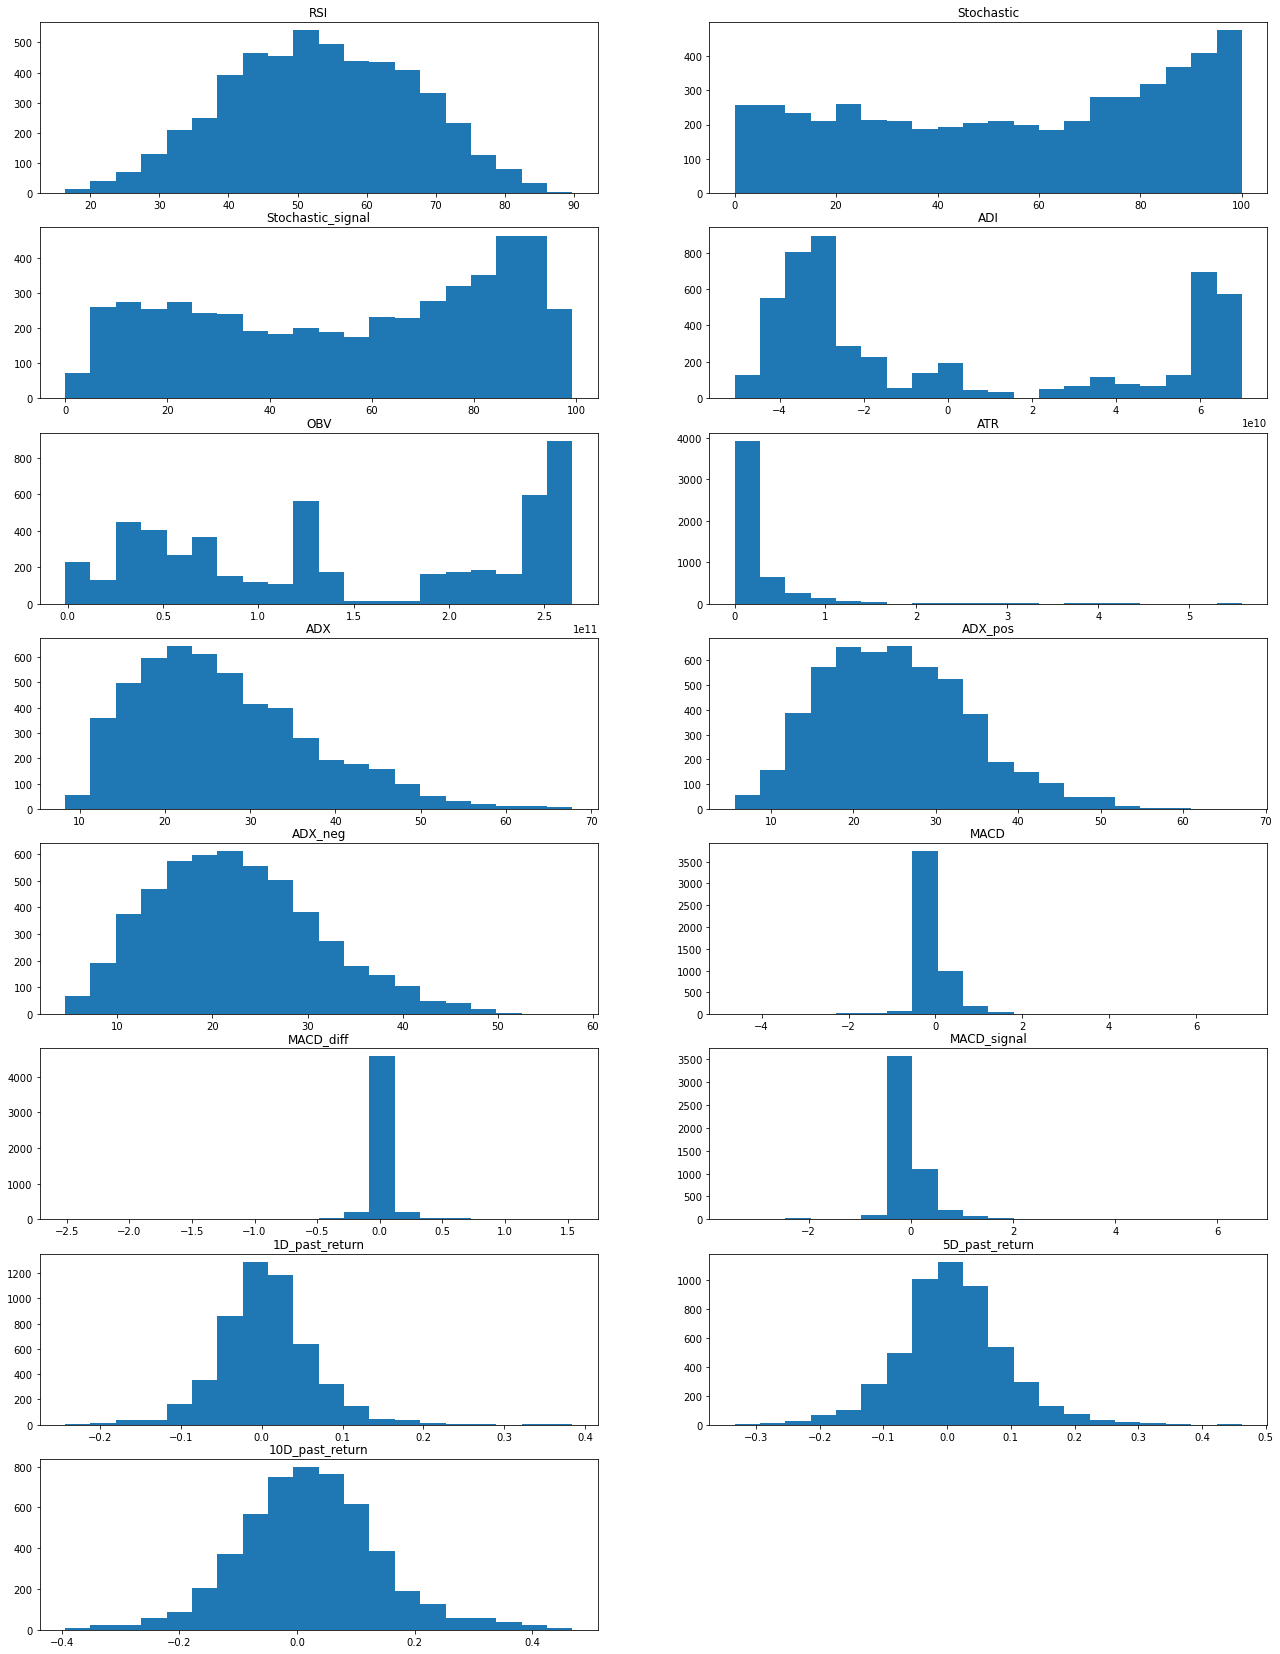

In [49]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(22, 56))
columns = 2
rows = len(INPUT_COLS)
for i, col in enumerate(INPUT_COLS):
    fig.add_subplot(rows, columns, i+1)
    plt.hist(ticker_train_x[col], bins=20)
    plt.title(col)
plt.show()

1. Join company dataset
2. Fit scaler
3. Pass companies 1 by 1 into build arrays (with fitted scaler)
4. Output scaled + outliered np.arrays

scaler = 'Dict'

1. input full dataset
2. run the scaler
3. tickers -> check outliers and scale the data
4. train_x, train_y, test_x, test_y, scaler


1. input full dataset
2. per ticker -> window + check outliers + mark_windows
3. append to master_df without outliers
4. scale 
5. windows into np.arrays


1. input full dataset
1.1. train test split
2. create outlier free dataset --> train
3. fit the scaler on train without outliers
4. ticker by ticker --> window on original full dataset-> check window for outliers
5. scale the window with the pre_fitted_scaler
6. append to the master array
7. output -> train_x, train_y, test_x, test_y, scaler

Extra: DF output +  window_num + sample_num

## Full Dataset Build Array Redo

1. input full dataset
1.1. train test split
2. create outlier free dataset --> train
3. fit the scaler on train without outliers
4. ticker by ticker --> window on original full dataset-> check window for outliers
5. scale the window with the pre_fitted_scaler
6. append to the master array
7. output -> train_x, train_y, test_x, test_y, scaler

extras --> return dataframe, convert to binary, ability to define Scaler

In [312]:
from mlchartist.preprocessing import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def full_dataset_randomised_arrays(df, 
                                         test_set_size='3Y', 
                                         time_window=5, 
                                         stride=3, 
                                         check_train_outliers=False, 
                                         check_test_outliers=False, 
                                         outlier_threshold=1, 
                                         input_cols=['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 
                                                     'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff', 'MACD_signal', '1D_past_return', 
                                                     '5D_past_return', '10D_past_return'], 
                                         target_col=['1D_past_return', '5D_past_return', '10D_past_return'], 
                                         outlier_validation={'ATR': [-100, 100], 'Stochastic': [0, 100], 
                                                             'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}):
    """
    A function to transform dataframe into input and output arrays.

    Takes:
    df - input dataframe
    time_window (default=5) - time series length
    stride (default=3) - controls the number of windows taken (i.e. max_num_windows = len(df)/strides)
    check_outliers (default=False) - controls whether it checks each window for outliers or not
    input_cols (default = 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']) - all input features, that should 
       be included in the input array target_col (default = '5TD_return') - target variable, first 
       (newest) value for each input array
    target_col - all columns that should be included in target_col
        (default: target_col=['1D_past_return', '5D_past_return', '10D_past_return'])
    outlier_validation - a dict that sets the outlier checks to be completed. Enter data in the format:
        outlier_validation={'column_name': [lower_threshold, upper_threshold]} 
        Example: {'Stochastic': [0, 100], 'Stochastic_signal': [-10, 110], '5D_past_return': [-0.5, 0.5]}

    Return tuple (input_array, target_array).

    input_array dim: (number_of_samples x time_window x features_number)
    target_array dim: (number_of_samples x time_window x returns_numbder)
    """
    
    ## split into train/test split
    raw_train_set = pd.DataFrame()
    raw_test_set = pd.DataFrame()
    for ticker in df['ticker'].unique():
        company_df = df[df['ticker'] == ticker]
        temp_train_set, temp_test_set = train_test_split(company_df, test_set_size)
        raw_train_set = raw_train_set.append(temp_train_set)
        raw_test_set = raw_test_set.append(temp_test_set)
        
    ## create copy of train_set & fit scaler
    no_outlier_train_df = raw_train_set.copy()
    for k, v in outlier_validation.items(): 
        no_outlier_train_df = no_outlier_train_df[no_outlier_train_df[k].between(v[0], v[1])]
    scaler = RobustScaler()
    scaler.fit(no_outlier_train_df[input_cols])
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    stats2 = []
    stats = {}
    ## go company by company
    print(f"{df['ticker'].unique().size} Companies in Dataset")
    status_count = 0
    for ticker in df['ticker'].unique():
        status_count +=1
        stats[ticker] = {}
        print(f"Starting {ticker}: Company {status_count} of {df['ticker'].unique().size}")
        train_outlier_count = 0
        test_outlier_count = 0
        company_train_x_array = []
        company_train_y_array = []
        
        company_test_x_array = []
        company_test_y_array = []

        ## train
        company_train_df = raw_train_set[raw_train_set['ticker'] == ticker]
        company_train_sorted = company_train_df.sort_values('date', ascending=False)
        company_train_sorted.reset_index(drop=True, inplace=True)
        for row in range(0, len(company_train_sorted), stride):
            outlier = False
            df_slice = company_train_sorted.iloc[row: row + time_window].copy()
            ## check for outliers
            if check_train_outliers == True:
                for k, v in outlier_validation.items(): 
                    if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
                
            if df_slice.shape[0]==time_window and outlier==False:
                ## scale the window
                df_slice.loc[:, input_cols] = scaler.transform(df_slice[input_cols])
                ## add to company array
                company_train_x_array.append(np.array(df_slice[input_cols].values))
                company_train_y_array.append(np.array(df_slice[target_col].values))
            else: train_outlier_count+=1
        
        if train_outlier_count/(len(company_train_sorted)/stride) <= outlier_threshold:
            stats[ticker]['train_possible_windows'] = (len(company_train_sorted)/stride)
            stats[ticker]['train_outliers'] = train_outlier_count
            stats[ticker]['train_windows'] = len(company_train_x_array)

            random.shuffle(company_train_x_array)
            random.shuffle(company_train_y_array)
            train_x.extend(company_train_x_array)
            train_y.extend(company_train_y_array)
            

        ## test
        company_test_df = raw_test_set[raw_test_set['ticker'] == ticker]
        company_test_sorted = company_test_df.sort_values('date', ascending=False)
        company_test_sorted.reset_index(drop=True, inplace=True)
        for row in range(0, len(company_test_sorted), stride):
            outlier = False
            df_slice = company_test_sorted.iloc[row: row + time_window].copy()
            ## check for outliers
            if check_test_outliers == True:
                for k, v in outlier_validation.items(): 
                    if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
                
            if df_slice.shape[0]==time_window and outlier==False:
                ## scale the window
                df_slice.loc[:, input_cols] = scaler.transform(df_slice[input_cols])
                ## add to company array
                company_test_x_array.append(np.array(df_slice[input_cols].values))
                company_test_y_array.append(np.array(df_slice[target_col].values))
            else: test_outlier_count+=1
        
        if train_outlier_count/(len(company_train_sorted)/stride) <= outlier_threshold:
            stats[ticker]['test_possible_windows'] = (len(company_test_sorted)/stride)
            stats[ticker]['test_outliers'] = test_outlier_count
            stats[ticker]['test_windows'] = len(company_test_x_array)
            random.shuffle(company_test_y_array)
            random.shuffle(company_test_y_array)
            test_x.extend(company_test_x_array)
            test_y.extend(company_test_y_array)
    
    print('All Companies Completed')
    print('')
    print('Processing Stats:', stats)
    random.shuffle(train_x)
    random.shuffle(train_y)
    random.shuffle(test_x)
    random.shuffle(test_y)
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y), scaler

In [313]:
INPUT_COLS = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
              'MACD_signal', '5TD_return', '10TD_return', '20TD_return']
TARGET_COLS=['5TD_return', '10TD_return', '20TD_return']
outlier_validation={'5TD_return': [-0.5, 0.5]}

stride = 50

train_x, train_y, test_x, test_y, scaler = full_dataset_randomised_arrays(joined_df, 
                                                                                stride=stride, 
                                                                                input_cols=INPUT_COLS, 
                                                                                outlier_threshold=1, 
                                                                                outlier_validation=outlier_validation, 
                                                                                check_train_outliers=True, 
                                                                                target_col=TARGET_COLS, 
                                                                                time_window=6)

print('')
print('')
print('### Stats ###')
print('train_x', train_x.shape)
print('train_y', train_y.shape)
print('test_x', test_x.shape)
print('test_y', test_y.shape)
print('scaler', scaler)

print('')
print('')
print('### Validation ###')
print('apple_train', len(apple_train)/stride)
print('apple_test', len(apple_test)/stride)
print('google_train', len(google_train)/stride)
print('google_test', len(google_test)/stride)
print('amazon_train', len(amazon_train)/stride)
print('amazon_test', len(amazon_test)/stride)



3 Companies in Dataset
Starting AAPL: Company 1 of 3
Starting GOOGL: Company 2 of 3
Starting AMZN: Company 3 of 3
All Companies Completed

Processing Stats: {'AAPL': {'train_possible_windows': 167.28, 'train_outliers': 0, 'train_windows': 168, 'test_possible_windows': 15.02, 'test_outliers': 1, 'test_windows': 15}, 'GOOGL': {'train_possible_windows': 66.66, 'train_outliers': 0, 'train_windows': 67, 'test_possible_windows': 15.02, 'test_outliers': 1, 'test_windows': 15}, 'AMZN': {'train_possible_windows': 103.06, 'train_outliers': 1, 'train_windows': 103, 'test_possible_windows': 15.02, 'test_outliers': 1, 'test_windows': 15}}


### Stats ###
train_x (338, 6, 15)
train_y (338, 6, 3)
test_x (45, 6, 15)
test_y (45, 6, 3)
scaler RobustScaler()


### Validation ###
apple_train 167.28
apple_test 15.02
google_train 66.66
google_test 15.02
amazon_train 103.06
amazon_test 15.02


In [299]:
print(f"{joined_df['ticker'].unique().size} Companies in Dataset")

3 Companies in Dataset


In [296]:
joined_df['ticker'].unique().size

3

In [251]:
train_y.shape

(4791, 6, 3)

In [252]:
test_x.shape

(30, 6, 15)

In [247]:
test_y.shape

(30, 6, 3)

In [197]:
test_y.shape

AttributeError: 'list' object has no attribute 'shape'

In [216]:
scaler

RobustScaler()

In [172]:
import random
my_array = [1, 2, 3, 4, 5]
random.shuffle(my_array)
print(my_array)

[4, 3, 1, 2, 5]


In [131]:
apple = pd.read_csv('../raw_data/processed/AAPL.csv')
google = pd.read_csv('../raw_data/processed/googl.csv')
amzn = pd.read_csv('../raw_data/processed/amzn.csv')

In [135]:
print('apple', len(apple))
print('google', len(google))
print('amzn', len(amzn))

print(len(apple) + len(google) + len(amzn))

apple 9115
google 4084
amzn 5904
19103


In [136]:
joined_df = pd.DataFrame()
joined_df = joined_df.append(apple)
joined_df = joined_df.append(google)
joined_df = joined_df.append(amzn)

print('joined_df', len(joined_df))

joined_df 19103


In [144]:
joined_df['ticker'].unique()[0]

'AAPL'

In [264]:
apple_train, apple_test = train_test_split(apple, '3Y')
google_train, google_test = train_test_split(google, '3Y')
amazon_train, amazon_test = train_test_split(amzn, '3Y')

print('trains', len(apple_train) + len(google_train) + len(amazon_train))
print('tests', len(apple_test) + len(google_test) + len(amazon_test))

print('apple_train', len(apple_train))
print('apple_test', len(apple_test))
print('google_train', len(google_train))
print('google_test', len(google_test))

trains 16850
tests 2253
apple_train 8364
apple_test 751
google_train 3333
google_test 751


In [142]:
raw_train_set, raw_test_set = train_test_split(joined_df, '3Y')

print('joined_df', len(joined_df))
print('raw_train_set', len(raw_train_set))
print('raw_test_set', len(raw_test_set))

joined_df 19103
raw_train_set 14164
raw_test_set 2253


In [148]:
joined_df.keys()

Index(['ticker', 'date', 'RSI', 'Stochastic', 'Stochastic_signal', 'ADI',
       'OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
       'MACD_signal', '5TD_return', '10TD_return', '20TD_return'],
      dtype='object')

In [130]:
scaler

RobustScaler()

In [121]:
train_set.head()

,date,ticker,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,1D_past_return,5D_past_return,10D_past_return
0,1984-10-24,AAPL,57.978007,76.690103,69.424914,-5.139242e+09,387549732,0.003297,19.036526,35.250645,23.135370,-0.000432,0.001254,-0.001687,-0.052010,-0.018263,-0.119206
1,1984-10-25,AAPL,49.247645,56.625203,68.325221,-5.322591e+09,204200382,0.003326,18.051296,32.458308,29.224107,-0.000390,0.001037,-0.001427,-0.009378,-0.022156,-0.060181
2,1984-10-26,AAPL,44.483899,43.374797,58.896701,-5.425815e+09,71070262,0.003286,17.088681,30.521333,33.447714,-0.000548,0.000704,-0.001251,0.009726,-0.055397,-0.026218
3,1984-10-29,AAPL,45.183124,44.997296,48.332432,-5.484525e+09,129780480,0.003117,16.194824,29.881216,32.746222,-0.000641,0.000488,-0.001129,0.000000,-0.025925,-0.003162
4,1984-10-30,AAPL,48.093222,51.703624,46.691906,-5.570994e+09,216248865,0.003048,15.133939,31.950924,31.104445,-0.000608,0.000417,-0.001025,0.048060,-0.060959,0.035265


In [96]:
test_set.head()

,date,ticker,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,ADX_neg,MACD,MACD_diff,MACD_signal,1D_past_return,5D_past_return,10D_past_return
0,2018-01-02,AAPL,52.023193,38.152401,23.652648,6.533415e+10,254106448700,0.580472,13.608768,25.773273,27.130529,0.102056,-0.121981,0.224037,0.012041,0.039743,-0.027992
1,2018-01-03,AAPL,51.940290,37.787056,27.077955,6.523801e+10,253983966278,0.583509,13.326351,30.417985,25.061481,0.098540,-0.100397,0.198938,0.011971,0.040884,-0.025872
2,2018-01-04,AAPL,54.143797,48.016701,41.318720,6.527281e+10,254076862673,0.566044,13.064107,29.116762,23.989399,0.110298,-0.070912,0.181210,0.012947,0.031372,-0.072472
3,2018-01-05,AAPL,58.989231,72.494781,52.766180,6.533808e+10,254174944719,0.565755,13.494921,32.807955,22.287245,0.155667,-0.020435,0.176101,0.011877,0.011473,-0.105798
4,2018-01-08,AAPL,57.011158,65.031315,61.847599,6.529933e+10,254089607326,0.554130,13.975125,31.838404,21.129476,0.178030,0.001543,0.176487,0.010320,0.015159,-0.065164


In [223]:
input_cols = ['RSI', 'Stochastic', 'Stochastic_signal', 'ADI','OBV', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff',
              'MACD_signal', '5TD_return', '10TD_return', '20TD_return']
target_col=['5TD_return', '10TD_return', '20TD_return']
check_outliers = True
stride = 50
time_window = 6
company_train_sorted = apple_train.sort_values('date', ascending=False)
company_train_sorted.reset_index(drop=True, inplace=True)

outlier_count = 0
company_train_x_array = []
company_train_y_array = []

for row in range(0, len(company_train_sorted), stride):
    outlier = False
    df_slice = company_train_sorted.iloc[row: row + time_window]
    ## check for outliers
    if check_outliers == True:
        for k, v in outlier_validation.items(): 
            if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True

    if df_slice.shape[0]==time_window and outlier==False:
        ## scale the window
        df_slice.loc[:, input_cols] = scaler.transform(df_slice[input_cols])
        ## add to company array
        company_train_x_array.append(np.array(df_slice[input_cols].values))
        company_train_y_array.append(np.array(df_slice[target_col].values))
    else: outlier_count+=1

print('possible_windows', (len(company_train_sorted)/stride))
print('outliers', outlier_count)
print('windows', len(company_train_x_array))

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

possible_windows 167.28
outliers 0
windows 168


c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
c:\users\owner\.venvs\lewagon\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [ ]:
input_array = []
    target_array = []
    df_sorted = df.sort_values('date', ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)    
    max_num_windows = len(df)/stride
    random_index = []
    for i in range(int(max_num_windows)):
        r=random.randint(time_window, len(df)- time_window)
        if r not in random_index: random_index.append(r)
    outlier_count = 0
    for window_start in random_index:
        outlier = False
        df_slice = df_sorted.iloc[window_start: window_start + time_window]
        if check_outliers == True:
            for k, v in outlier_validation.items(): 
                if ((df_slice[k] < v[0]).any() == True) or ((df_slice[k] > v[1]).any() == True): outlier = True
        if df_slice.shape[0]==time_window and outlier==False:
            if outlier_count/max_num_windows >= outlier_threshold:
                return np.array([]), np.array([])
            input_array.append(np.array(df_slice[input_cols].values))
            target_array.append(np.array(df_slice[target_col].values))
        else: outlier_count+=1
    print('random_index', random_index)
    print('outlier_count', outlier_count)
    print('max_num_windows', max_num_windows)
    print('random_index', len(random_index))
    print('input_array', len(input_array))
    print('outlier %', outlier_count/max_num_windows)  

In [93]:
def train_test_split(df, test_set_size):
    """
    Split the preprocessed stock data file into a train and test dataset
    INPUT: the dataframe to be split, and size of the test set in months or years ('3M' or '2Y')
    OUTPUT: returns a train_set and test_set dataframe, index is set to the date

    EXAMPLE: train_set, test_set = train_test_split(input_df, '3Y')  --> puts last 3 years in test_set
    """
    if not np.issubdtype(df['date'].dtype, np.datetime64):
        df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d'))
    test_set = df.sort_values(by="date",ascending=True).set_index("date").last(test_set_size)
    train_set = df.drop(df.tail(len(test_set)).index).set_index("date")
    test_set.reset_index(inplace=True)
    train_set.reset_index(inplace=True)
    return None